# Importing Libraries and Loading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
df = pd.read_csv("../input/online-retail-customer-clustering/OnlineRetail.csv", delimiter=',', encoding = "ISO-8859-1")

# Observing Datatypes, Columns and Rows

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Data Cleaning: Checking for Null Values

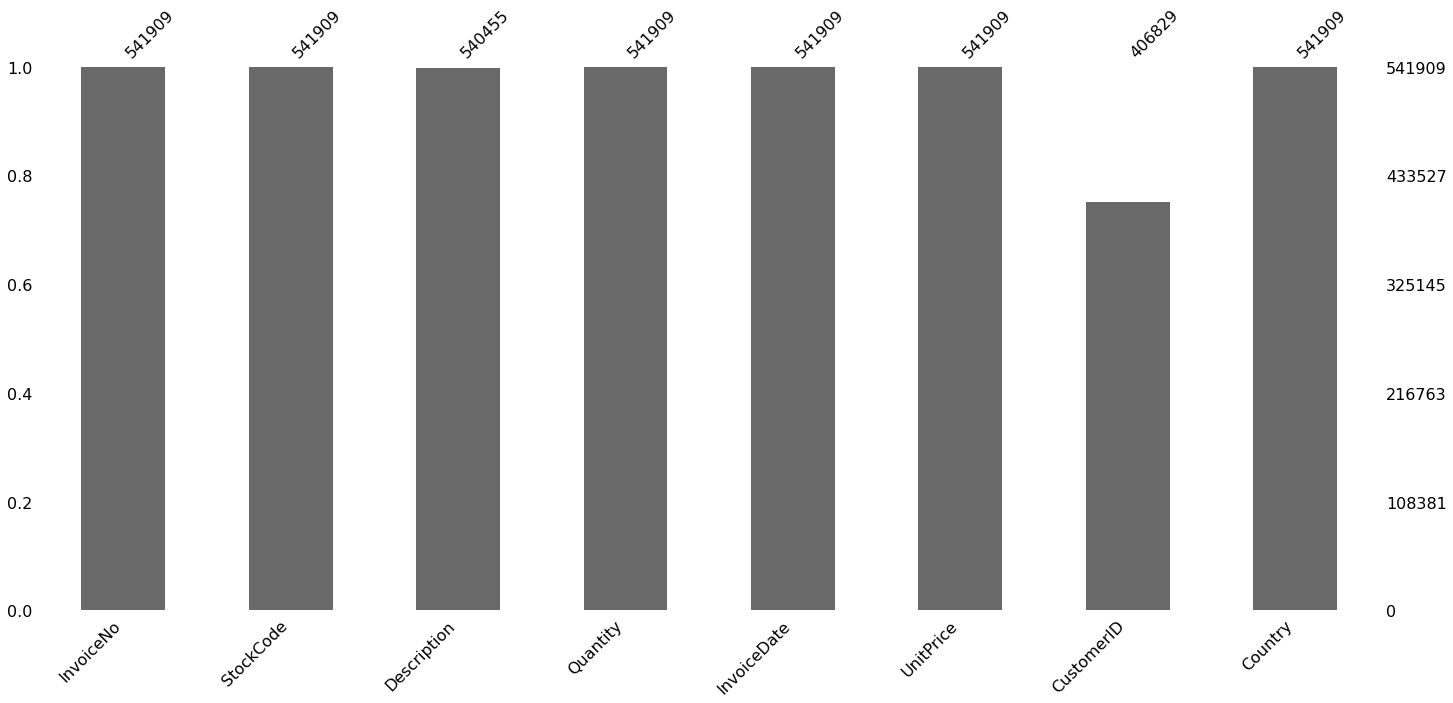

In [6]:
msno.bar(df)

* We observed that CustomerID is missing.
* We will first check approximately how many rows are mssing this detail
* Then we will delete the missing rows. 
* The type of analysis I will be performing requires groupby according to customers so that is why it is necessary to remove null values from this column. 

In [7]:
df.count()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

In [8]:
df[df['CustomerID'].isnull()].count()

InvoiceNo      135080
StockCode      135080
Description    133626
Quantity       135080
InvoiceDate    135080
UnitPrice      135080
CustomerID          0
Country        135080
dtype: int64

* Approximately 25% of the data is missing.
* We will prooceed with dropping the missing rows now.

In [10]:
df.dropna(inplace=True)

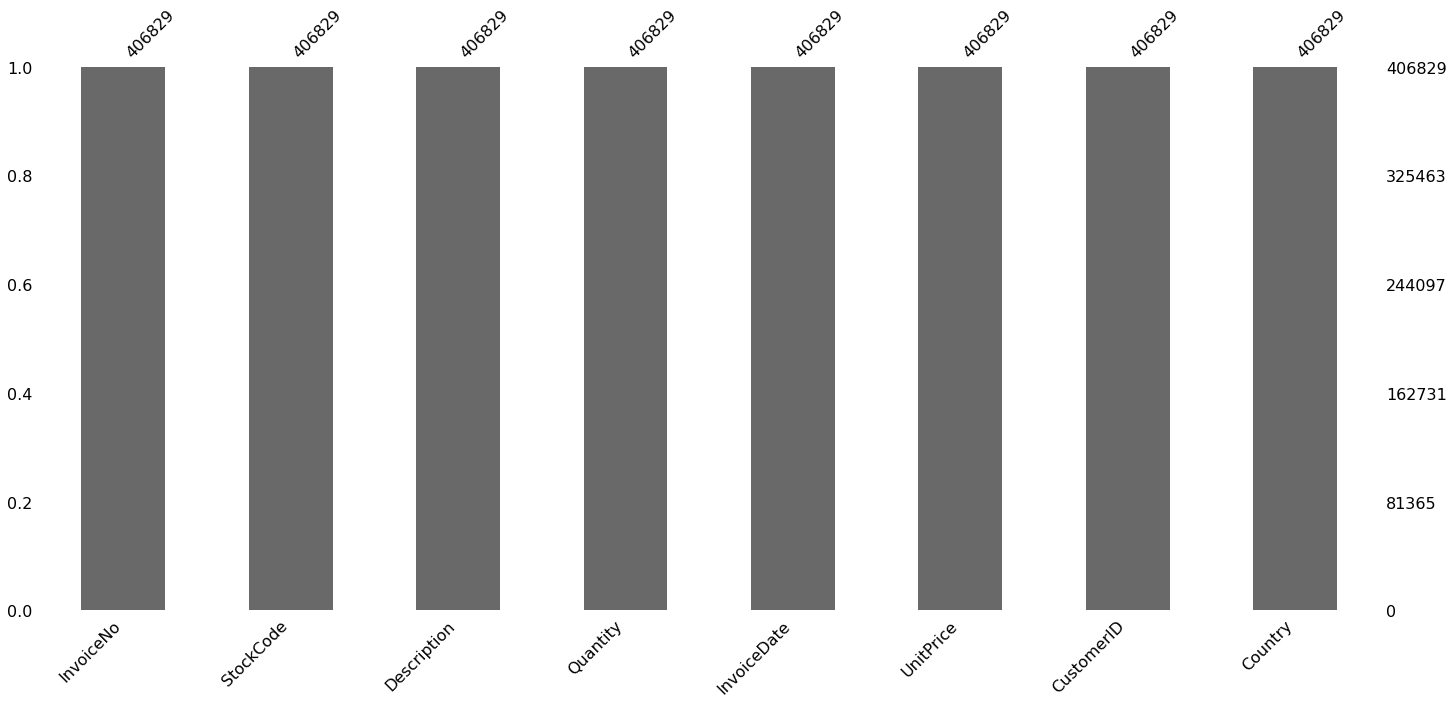

In [11]:
msno.bar(df)

* Now we can see above that the matrix is showing all bars are equal
* meaning that the data is clean and ready to be used in the model
* meanwhile we will change the data type of InvoiceDate to Datetime.
* We will also create three new fields:

# Amount

In [13]:
df['Total Amount Spent']= df['Quantity'] * df['UnitPrice']

total_amount = df['Total Amount Spent'].groupby(df['CustomerID']).sum()
total_amount = pd.DataFrame(total_amount).reset_index()
total_amount.head()

,CustomerID,Total Amount Spent
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


# Number of Transactions

In [14]:
transactions = df['InvoiceNo'].groupby(df['CustomerID']).count()
transaction = pd.DataFrame(transactions).reset_index()
transaction.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


# Last Transaction (LT)

In [15]:
final = df['InvoiceDate'].max()
df['Last_transact'] = final - df['InvoiceDate']
LT = df.groupby(df['CustomerID']).min()['Last_transact']
LT = pd.DataFrame(LT).reset_index()
LT.head()

,CustomerID,Last_transact
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


# Merging All the newly created columns

In [16]:
df_new = pd.merge(total_amount, transaction, how='inner', on='CustomerID')

In [17]:
df_new = pd.merge(df_new, LT, how='inner', on='CustomerID')

 Last Transact column still needs to be simplified for just number of days

In [18]:
df_new.head()

,CustomerID,Total Amount Spent,InvoiceNo,Last_transact
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [19]:
df_new['Last_transact'] = df_new['Last_transact'].dt.days

In [20]:
df_new.head()

,CustomerID,Total Amount Spent,InvoiceNo,Last_transact
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


# K Means Clustering Model

In [21]:
from sklearn.cluster import KMeans

In [22]:
kmeans= KMeans(n_clusters=2)
kmeans.fit(df_new[['Total Amount Spent', 'InvoiceNo', 'Last_transact']])
pred = kmeans.predict(df_new[['Total Amount Spent', 'InvoiceNo', 'Last_transact']])

In [23]:
kmeans.cluster_centers_

array([[1.65070406e+03, 9.06685754e+01, 9.11630783e+01],
       [1.82181982e+05, 1.82833333e+03, 6.66666667e+00]])

In [24]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [25]:
pred = pd.DataFrame(pred, columns=['pred'])
df_new = df_new.join(pred)

# Clusters are created!

* we will now visualize them using different analytics tools and plots. 
* KMeans Clustering is unsupervised learning model so this means we do not really have anything to compare it with. 
* However we will try to visualize and make assumptions of how it actually made the segmentation

Text(0.5, 0, 'Clusters')

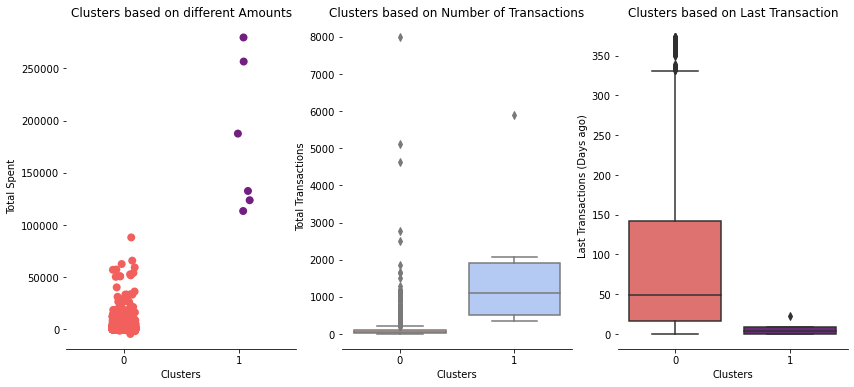

In [26]:
fig, ax =plt.subplots(nrows= 1, ncols = 3, figsize= (14,6))
ty=sns.stripplot(x='pred', y='Total Amount Spent', data=df_new, s=8, ax = ax[0], palette='magma_r')
sns.despine(left=True)
ty.set_title('Clusters based on different Amounts')
ty.set_ylabel('Total Spent')
ty.set_xlabel('Clusters')

tt=sns.boxplot(x='pred', y='InvoiceNo', data=df_new, ax = ax[1], palette='coolwarm_r')
tt.set_title('Clusters based on Number of Transactions')
tt.set_ylabel('Total Transactions')
tt.set_xlabel('Clusters')

tr=sns.boxplot(x='pred', y='Last_transact', data=df_new, ax = ax[2], palette='magma_r')
tr.set_title('Clusters based on Last Transaction')
tr.set_ylabel('Last Transactions (Days ago)')
tr.set_xlabel('Clusters')